In [ ]:
from typing import Literal, List, Annotated
from typing_extensions import TypedDict
from langgraph.graph import MessagesState
from pydantic import BaseModel
from langchain_core.messages import AnyMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
import random

# Dataclasses for nodes outputs
class evaluateDocumentsOutput(BaseModel):
    evaluation: Literal["yes", "no"]
    additional_context: str

class evaluateAnswersOutput(BaseModel):
    evaluation: Literal["yes", "no"]
    additional_context: str

# State class
class overallState(TypedDict):
    prompt: str
    messages: Annotated[list[AnyMessage], add_messages]
    summary: str
    web_documents: List[str]
    documents : List[str]
    answer_elements: str
    additional_context: str
    react_loop_limit: int
    reformulate_loop_limit: int
    generation: str
    good_docs: bool
    ready_to_ans: bool

class teacherState(TypedDict):
    pass
class styleagentState(TypedDict):
    pass

### Main Graph

In [ ]:
# Automatic Tools
@tool
def web_search(research):
    """
    Automatic callable function for web search
    """
    return None
@tool
def wiki_search(research):
    """
    Automatic callable function for wiki search
    """
    return None
tools = [web_search, wiki_search]

# Nodes
def is_answer(state: overallState):
    """
    evaluate if the last prompt is a answer to a system question
    """
    print("---ANSWER-COMMENT IF APPLIES---")
    answ_eval = "evaluation answer"
    if answ_eval == "yes":
        return {"answer_elements": answ_eval}
    else:
        return {"answer_elements": "no"}

def retrive_documents(state: overallState):
    """
    retrive documents from the vector store
    """
    print("---RETRIVE DOCUMENTS---")
    docs = ["doc1", "doc2", "doc3"]
    return {"documents": docs}

def web_search_agent(state: overallState):
    """
    search for documents in the web using a ReAct agent
    """
    print("---WEB SEARCH AGENT---")
    docs = ["doc1", "doc2", "doc3"]
    return {"documents": docs}

def complement_localRAG(state: overallState):
    """
    When the router decides to use the internal RAG, this function will complement the information doing a web search
    """
    print("complement_localRAG")
    docs = state["documents"]
    docs.append("doc4")
    return {"documents": docs}

def evaluate_documents(quesiton, documents):
    """
    Evaluate the documents in the context of the question
    """
    print("----EVALUATE DOCUMENTS-----")
    answer = evaluateDocumentsOutput(answer_elements="yes", additional_context="context")
    good_docs = False
    if answer.evaluation == "yes":
        good_docs = True
    return {"good_docs": good_docs, "additional_context": answer.additional_context}

def generate_answer(state: overallState):
    """
    Generate the answer to the question
    """
    print("---GENERATE ANSWER---")
    answer = "answer"
    return {"answer_elements": answer}

def evaluate_answer(state: overallState):
    """
    Evaluate the answer in the current documents context
    """
    print("---EVALUATE ANSWER---")
    answer = evaluateAnswersOutput(answer_elements="yes", additional_context="context")
    good_output = False
    if answer.evaluation == "yes":
        good_output = True
    return {"ready_to_ans": good_output, "additional_context": answer.additional_context}

def reformulate(state: overallState):
    """
    Reformulate the question to get a better answer
    """
    print("---REFORMULATE---")
    return {"additional_context": "context"}
# edges

def create_router(state: overallState):
    """
    Router to decide if use the internal RAG or the external RAG tools as main 
    """
    print("---ACCEPT_PROMPT AND INITIAL ROUTER---")
    if random.random() < 0.33:
        return "vectorstore"
    elif random.random() > 0.33 and random.random() < 0.66:
        return "websearch"
    else:
        return "refuse"

def decide_to_generate(state: overallState):
    """
    Evaluate the documents in the context of the question
    """
    print("decide_to_generate")
    if evaluate_documents(state["prompt"], state["documents"]) == "yes":
        return "generate"
    else:
        return "reformulate"
def evaluate_answer(state):
    """
    Evaluate the answer in the context of the question
    """
    if random.random() > 0.5:
        return "end_answer"
    else:
        return "reformulate" # Adding some more context...

def conditional_tool_edge(state: overallState):
    """
    This functions decides if continue in the tools loop or go to the evaluate answer node
    """
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tool_node"
    else:
        return "validate_founds"


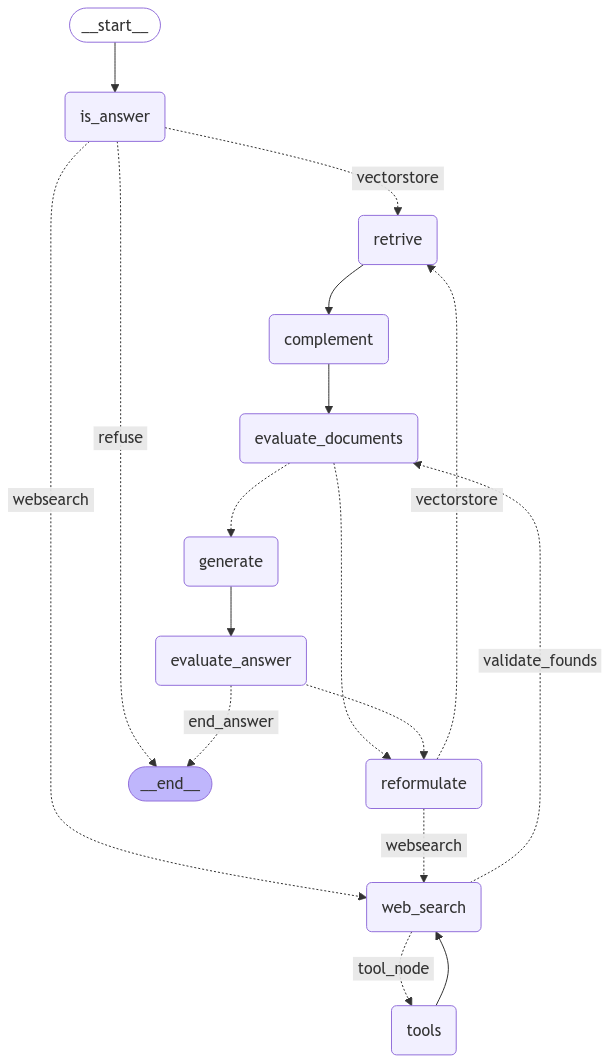

In [8]:
# Making graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.prebuilt import tools_condition


workflow = StateGraph(overallState)

#define the nodes
workflow.add_node("is_answer", is_answer)
workflow.add_node("retrive", retrive_documents)
workflow.add_node("web_search", web_search_agent)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("complement", complement_localRAG)
workflow.add_node("evaluate_documents", evaluate_documents)
workflow.add_node("generate", generate_answer)
workflow.add_node("reformulate", reformulate)
workflow.add_node("evaluate_answer", evaluate_answer)

# Build graph
workflow.add_edge(START, "is_answer")
workflow.add_conditional_edges("is_answer", create_router,
                               {"vectorstore": "retrive",
                                "websearch": "web_search",
                                "refuse": END}
                              )
workflow.add_edge("retrive", "complement")
workflow.add_conditional_edges("web_search", conditional_tool_edge,
                               {"tool_node": "tools",
                                "validate_founds": "evaluate_documents"}
                              )
workflow.add_edge("tools", "web_search")
workflow.add_edge("complement", "evaluate_documents")
workflow.add_conditional_edges("evaluate_documents", decide_to_generate,
                               {"generate": "generate",
                                "reformulate": "reformulate"}
                              )
workflow.add_conditional_edges("reformulate", create_router,
                               {"vectorstore": "retrive",
                                "websearch": "web_search"}
                              )
workflow.add_edge("generate", "evaluate_answer")
workflow.add_conditional_edges("evaluate_answer", evaluate_answer,
                               {"end_answer": END,
                                "reformulate": "reformulate"}
                              )

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### Teacher deep-reasoning graph

### Style Expert
Based only in the user prompts create an style prompt to give a in context answer